# Model Definition and Evaluation

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#functions

def readHdf5(path):  # use pandas to read data from the hdf5 file
    df = pd.read_hdf(path + 'h5File_FE.h5', 'df')
    return df

In [3]:
path = '../'
df = readHdf5(path)

In [4]:
df.head()

,date,origin,destination,departure-time,departure-delay,taxi-out,taxi-in,arrival-time,arrival-delay,air-time,carrier-delay,weather-delay,nas-delay,security-delay,late-aircraft-delay,month,day-of-the-month,day-of-the-week,delayed,status
342111,2019-02-12,163,185,0.808670,0.016538,0.13750,0.064516,0.888704,0.037459,0.269400,0.0,0.0,0.019608,0.0,0.0,2,12,1,True,1
298420,2019-07-14,57,122,0.885369,0.018008,0.05000,0.048387,0.977491,0.020198,0.162518,0.0,0.0,0.000000,0.0,0.0,7,14,6,False,0
275467,2019-04-27,243,20,0.431013,0.017273,0.04375,0.008065,0.556065,0.020198,0.147877,0.0,0.0,0.000000,0.0,0.0,4,27,5,False,0
271709,2019-06-03,163,187,0.596082,0.015803,0.11875,0.024194,0.648604,0.024238,0.250366,0.0,0.0,0.000000,0.0,0.0,6,3,0,False,0
50814,2019-10-09,232,207,0.841601,0.016538,0.06250,0.000000,0.931638,0.017260,0.081991,0.0,0.0,0.000000,0.0,0.0,10,9,2,False,0


In [5]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# 1. Feature Selection

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested. In this section, we will use three feature selection techniques for our target label *delayed* (classification):

* Feature Correlation
* Feature Importance
* Univariate Feature Selection

* **Feature Correlation**

First we use the simplest method, correlation, to compare all relevant features to our target: *delayed*.

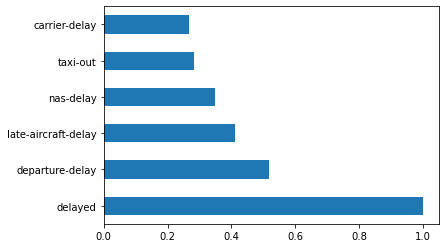

In [6]:
X = df[['origin','destination','departure-time','departure-delay','taxi-out','taxi-in',
        'arrival-time','air-time','carrier-delay','weather-delay','nas-delay','security-delay',
        'late-aircraft-delay','month','day-of-the-month','day-of-the-week','delayed']]  # features

df_corr = X.corr()['delayed'].sort_values(ascending=False).head(6)
top_corr_features = df_corr.index # plot top 5 (plus delayed) most correlated features to our target
df_corr.plot(kind='barh')
plt.show()

* **Feature Importance - Random Forests Classifier**

Bagged decision trees like Random Forest can be used to estimate the importance of features.

First, we separate the columns into dependent and independent variables (or features and labels).

In [7]:
X = df[['origin','destination','departure-time','departure-delay','taxi-out','taxi-in',
        'arrival-time','air-time','carrier-delay','weather-delay','nas-delay','security-delay',
        'late-aircraft-delay','month','day-of-the-month','day-of-the-week']]  # features
y = df['delayed']  # target

Next, we define the model, we fit it, get the features importances and summarize them in a plot.

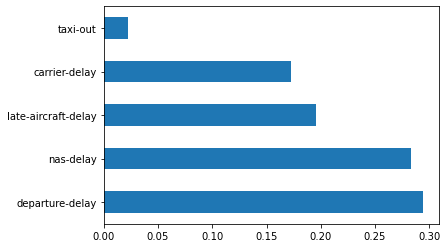

departure-delay        0.293994
nas-delay              0.283597
late-aircraft-delay    0.195651
carrier-delay          0.172461
taxi-out               0.021830
dtype: float64


In [8]:
from sklearn.ensemble import RandomForestClassifier

clf_rfc = RandomForestClassifier()
clf_rfc.fit(X, y)
importance = clf_rfc.feature_importances_

feat_importances = pd.Series(clf_rfc.feature_importances_, index=X.columns)
df_imp_feat = feat_importances.nlargest(5)

df_imp_feat.plot(kind='barh')
plt.show()
print(df_imp_feat)

Let's see what we obtain with Univariate Selection

* **Univariate Selection - SelectKBest**

Statistical tests can be used to select those features that have the strongest relationship with the output variable. The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

Here we instantiate SelectKBest to determine the k=5 best features.

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

k = 5

select_features = SelectKBest(f_classif, k=k).fit(X, y)

df_scores = pd.DataFrame(select_features.scores_)
X_columns = pd.DataFrame(X.columns)

feature_scores = pd.concat([X_columns, df_scores], axis=1)
feature_scores.columns = ['Feature Name','Score']  # name output columns
print(feature_scores.nlargest(k,'Score'))  # print k best features

           Feature Name         Score
3       departure-delay  58640.474308
12  late-aircraft-delay  32228.640285
10            nas-delay  21732.573529
4              taxi-out  13790.091547
8         carrier-delay  12241.039160


**Conclusion:** After the using the above three methods, it seems that the best might be to use only *departure-delay* and *taxi-out*, since they appear as the best two features in the three cases. However, some caution might be required since the scores of *taxi-out* were never very high. The remaining features have very low scores in all cases.

For these reasons, we will attempt to define models first with all features and then with the above two. The best results will guide us to select the right approach.

# 2. Implementation of Algorithms

We will test the following three approaches for our model:

* Classic ML Approach 1 - **Random Forest Classifier**
* Classic ML Approach 2 - **Support Vector Machine**
* Neural Network Approach - **Multi-Layer Perceptron Classifier**

We'll try to interpret the performance of the models using these measures:

1. **Accuracy** - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same.
2. **Precision** - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
3. **Recall** (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes.
4. **F1 score** - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

In [10]:
X = df[['origin','destination','departure-time','departure-delay','taxi-out','taxi-in',
        'arrival-time','air-time','carrier-delay','weather-delay','nas-delay','security-delay',
        'late-aircraft-delay','month','day-of-the-month','day-of-the-week']]  # all features

# only some selected features
X_selected = df[['departure-delay','taxi-out','nas-delay','late-aircraft-delay','carrier-delay']]

y = df['delayed']  # label

**Random Forest Classifier**

In [11]:
from sklearn.model_selection import train_test_split

# split data into training set (70 %) and test set (30 %)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Recall: 1.000
Precision: 1.000
Accuracy: 1.000
F1: 1.000
Feature importances: [0.001 0.001 0.002 0.267 0.024 0.004 0.004 0.001 0.167 0.017 0.296 0.001
 0.215 0.    0.    0.   ]


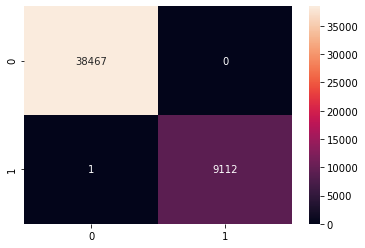

In [12]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

clf_rfc = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
y_pred = clf_rfc.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)

print('Recall: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('F1: {:.3f}'.format(f1_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

print('Feature importances: {}'.format(clf_rfc.feature_importances_))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

Recall: 0.995
Precision: 0.995
Accuracy: 0.998
F1: 0.995
Feature importances: [0.341 0.012 0.316 0.172 0.159]


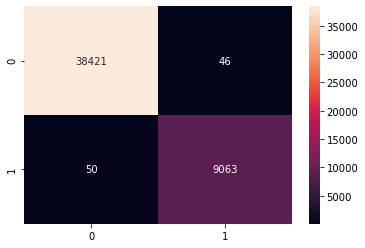

In [14]:
clf_rfc = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
y_pred = clf_rfc.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)

print('Recall: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('F1: {:.3f}'.format(f1_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

print('Feature importances: {}'.format(clf_rfc.feature_importances_))

So with this first model, we see that it actually performed better using all features, instead of only the *best* features according to classification (other tests were made using even less features and the results were even poorer.

Overall, all metrics are extremely high with RFC, so problably we won't get any better with SVM or with the MLPClassifier.

**Support Vector Machine**

The goal of the SVM algorithm is to find a hyperplane in an n-dimensional space (n is the number of features) that distinctly classifies the data points.

Here, we'll use a Gaussian RBF (Radial Basis Function) for the kernel, which is a function whose value depends on the distance from the origin or from some other point.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Recall: 0.018
Precision: 0.325
Accuracy: 0.805
F1: 0.034


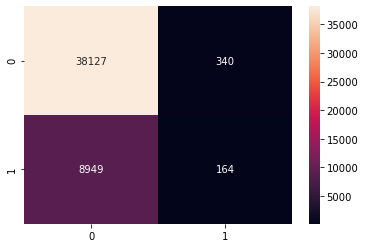

In [16]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1000, gamma=6, random_state=42).fit(X_train, y_train)
y_pred = svm.predict(X_test)

print('Recall: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('F1: {:.3f}'.format(f1_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

y_scores = svm.decision_function(X_test)
y_score_list = list(zip(y_test[0:20], y_scores[0:20]))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

Recall: 0.993
Precision: 0.998
Accuracy: 0.998
F1: 0.995


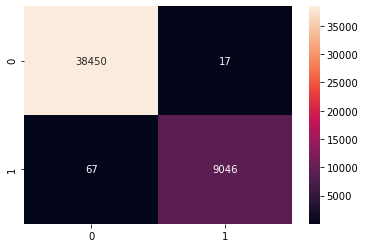

In [18]:
svm = SVC(kernel='rbf', C=1000, gamma=6, random_state=42).fit(X_train, y_train)
y_pred = svm.predict(X_test)

print('Recall: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('F1: {:.3f}'.format(f1_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

y_scores = svm.decision_function(X_test)
y_score_list = list(zip(y_test[0:20], y_scores[0:20]))

As expected, SVM gives worse predictions than RFC for our data. However, for the shorter group of features it did work almost as good as RFC. Great results!

Let's try now with a DeepLearning Algorithm.

**Multi-Layer Perceptron Classifier**

One can do simple deep learning regression and classification models with the scikit-learn package. However, for most real-life large-scale projects, these algorithms might not be the best choice as there is no GPU support and very limited options to tweak the parameters.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Recall: 0.984
Precision: 0.997
Accuracy: 0.996
F1: 0.990


<AxesSubplot:>

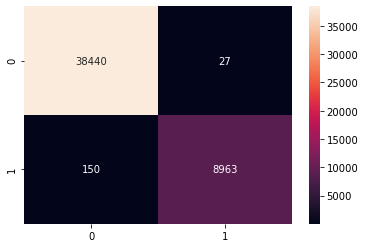

In [20]:
from sklearn.neural_network import MLPClassifier

clf_nn = MLPClassifier(hidden_layer_sizes = [5,5], solver='adam', alpha=0.0003, activation='relu',
                     max_iter = 100, random_state = 42).fit(X_train, y_train)
y_pred = clf_nn.predict(X_test)

print('Recall: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('F1: {:.3f}'.format(f1_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

We can calculate the best parameters for the model using *GridSearchCV*. The input parameters 
for the GridSearchCV method are
 
1. The MLP model
2. A parameter dictionary in which we define various hidden layers, activation units, learning rates.

It trains the model and finds the best parameter.

In [21]:
from sklearn.model_selection import GridSearchCV

check_parameters = {
    'hidden_layer_sizes': [(50,50), (100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [22]:
gridsearchcv = GridSearchCV(clf_nn, check_parameters, n_jobs=-1, cv=3)
gridsearchcv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MLPClassifier(alpha=0.0003, hidden_layer_sizes=[5, 5],
                                     max_iter=100, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50), (100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [23]:
print('Best parameters found:\n', gridsearchcv.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


Recall: 0.999
Precision: 0.997
Accuracy: 0.999
F1: 0.998


<AxesSubplot:>

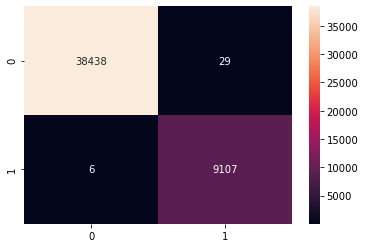

In [25]:
clf_nn = MLPClassifier(hidden_layer_sizes = (100, 50), solver='adam', alpha=0.0001, activation='relu',
                     max_iter=300, learning_rate='constant', random_state = 42).fit(X_train, y_train)
y_pred = clf_nn.predict(X_test)

print('Recall: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('F1: {:.3f}'.format(f1_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

As shown above, the metrics give much better scores with the parameters given by *GridSearchCV*. Let's do the same process now for the *selected* features.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

Recall: 0.994
Precision: 0.996
Accuracy: 0.998
F1: 0.995


<AxesSubplot:>

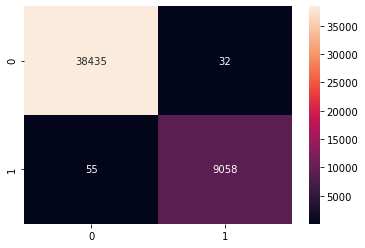

In [27]:
clf_nn = MLPClassifier(hidden_layer_sizes = [5,5], solver='adam', alpha=0.0003, activation='relu',
                     max_iter = 100, random_state = 42).fit(X_train, y_train)
y_pred = clf_nn.predict(X_test)

print('Recall: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('F1: {:.3f}'.format(f1_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [28]:
gridsearchcv = GridSearchCV(clf_nn, check_parameters, n_jobs=-1, cv=3)
gridsearchcv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MLPClassifier(alpha=0.0003, hidden_layer_sizes=[5, 5],
                                     max_iter=100, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50), (100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [29]:
print('Best parameters found:\n', gridsearchcv.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


Recall: 0.995
Precision: 0.997
Accuracy: 0.998
F1: 0.996


<AxesSubplot:>

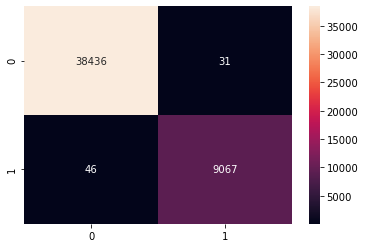

In [30]:
clf_nn = MLPClassifier(hidden_layer_sizes = (100, 50), solver='adam', alpha=0.0001, activation='relu',
                     max_iter=300, learning_rate='constant', random_state = 42).fit(X_train, y_train)
y_pred = clf_nn.predict(X_test)

print('Recall: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('F1: {:.3f}'.format(f1_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

Overall, the last algorithm is giving the best performances for both groups of features, which might suggest that a bit more of tweaking and tuning could make it work ever better.

# Summary of the conclusions

As a conclusion we can say that flight delays seem to be predictible from the information related to previous flights. In particular, for our models it was enough to use the encoded cathegorical features *origin* and *destination*, plus the quantitative features *departure-time*, *departure-delay*, *taxi-out*, *taxi-in*, *arrival-time*, *air-time*, *carrier-delay*, *weather-delay*, *nas-delay*, *security-delay*, *late-aircraft-delay* and the seasonal features *month*, *day-of-the-month* and *day-of-the-week*.

We have noted that, according to all measures used, *departure-delay* is by far the most important feature when predicting *delayed* flights. This is something one could have expected, since a delay at departure will lead to a delayed flight in most cases.